## Set up

In [ ]:
# Check if all required packages are successfully imported
try:
    import os
    import random
    import subprocess
    import numpy as np
    import pandas as pd
    import pandas_plink as ppl
    import statsmodels.api as sm
    import matplotlib.pyplot as plt
    print("All packages imported successfully!")
except ImportError as e:
    print(f"ImportError: {e}. Please follow the steps in the README to set up the environment correctly.")

All packages imported successfully!


Create a temporary folder to store all unzipped files and intermediate outputs throughout the analysis

In [2]:
%%bash
mkdir -p temp_dir 
gunzip -c data/GD462.GeneQuantRPKM.50FN.samplename.resk10.txt.gz > temp_dir/GD462.GeneQuantRPKM.50FN.samplename.resk10.txt
gunzip -c data/gene_annot.txt.gz > temp_dir/gene_annot.txt

## Analysis

### run cis-eQTL analysis
In this section, I will perform a cis-eQTL analysis for all protein coding genes on chromosome 1-22 using 1000 Genome data (stored in the `data/LDREF` folder)

#### extract bed

In [14]:
%%bash
mkdir -p temp_dir/eqtl
mkdir -p temp_dir/eqtl/locs
mkdir -p temp_dir/eqtl/plink_files

In [15]:
gene_annot = pd.read_csv('temp_dir/gene_annot.txt', sep='\t')
genes = gene_annot[gene_annot['TYPE'] == 'protein_coding'] # keep only protein coding genes

In [16]:
genes_15 = genes[genes['CHR'] == 15] # only include chromosome 15

In [17]:
# generate coordinate files for each gene
for i, row in genes_15.iterrows():
    with open(f"temp_dir/eqtl/locs/{row['CHR']}_{row['ID']}_coords.txt", 'w') as f:
        f.write(f"chr{row['CHR']}\t{row['START']-500000}\t{row['STOP']+500000}\t{row['ID']}\t0\t+\n") # +- 500 kb 'cis'

Now I will use **PLINK2** to extract the BED file for each gene.  
Please ensure that **PLINK2** is installed and executable in the GitHub directory.

- **Execution Time:**  
  There are approximately 20,000 genes, so this make take a few minutes to run.

- **Output Suppression:**  
  To keep the output concise, I have suppressed all PLINK output, as it can be quite lengthy.

- **Potential Errors:**  
  1. You may encounter the error:  
     **`No variants remaining after main filters.`**  
     This is completely normal and indicates that there are no SNPs associated with those genes.
  2. You may also encounter the error:  
     **`Invalid range...`**  
     This occurs for genes located near the ends of chromosomes, where there are insufficient SNPs in the flanking regions. 
     
For now, I will exclude all such genes, as we have many genes to analyze.


In [18]:
input_dir = "temp_dir/eqtl/locs"
output_dir = "temp_dir/eqtl/plink_files"
plink_executable = "./plink2"

for f in os.listdir(input_dir):
    if f.endswith('_coords.txt'):
        gene = f.split('_')[1]
        chr = f.split('_')[0]
        input_file = os.path.join(input_dir, f)
        output_file = os.path.join(output_dir, f"1000G.EUR.{chr}.{gene}")
        plink_command = [
            plink_executable,
            "--bfile", f"data/LDREF/1000G.EUR.{chr}",
            "--extract", "bed1", input_file,
            "--out", output_file,
            "--make-bed"
        ]
        try:
            subprocess.run(plink_command, stdout=subprocess.DEVNULL, stderr=subprocess.PIPE, check=True)
        except subprocess.CalledProcessError as e:
            print(f"{gene}: {e.stderr.decode()}")

#### find overlapping data

In [19]:
gene_exp = pd.read_csv('temp_dir/GD462.GeneQuantRPKM.50FN.samplename.resk10.txt', sep='\t')
gene_exp['SYM'] = gene_exp['Gene_Symbol'].apply(lambda x: x.split('.')[0])
gene_exp_genes = gene_exp['SYM'].tolist()

In [20]:
# The samples in the gene expression data do not exactly match those in the genome data from the 1000 Genomes Project. Therefore, we will do some additional cleaning
(bim, fam, bed) = ppl.read_plink(f'data/LDREF/1000G.EUR.15')
overlap_idx_genome = np.where(np.isin(fam['iid'], gene_exp.columns))[0]
gene_exp_overlap = gene_exp[['TargetID', 'Gene_Symbol', 'Chr', 'Coord', 'SYM'] + list(fam['iid'].to_numpy()[overlap_idx_genome])]

# Similarly, some genes are missing from the gene expression data. Identifying those missing genes...
missing_genes = [genes_15[genes_15['SYM'] == g]['ID'].iloc[0] for g in genes_15['SYM'] if g not in gene_exp_genes]


Mapping files: 100%|██████████| 3/3 [00:00<00:00, 10.57it/s]


#### cis-eQTL - run

In [21]:
%%bash
mkdir -p result # a folder for final results
mkdir -p result/eqtl

In [23]:
# this takes approximately 22 minutes on my end

eqtl_results = []
for f in os.listdir('temp_dir/eqtl/plink_files'):
    if f.startswith(f'1000G.EUR.15') and f.endswith('.bed'):
        prefix = f.split('.bed')[0]
        gid = f.split('.')[3]
        gsym = genes_15[genes_15['ID'] == gid]['SYM'].iloc[0]
        if gid not in missing_genes:
            (bim, fam, bed) = ppl.read_plink(f'temp_dir/eqtl/plink_files/{prefix}')
            bed_sample_filtered = bed.compute()[:, overlap_idx_genome]
            for snp_i in range(bim.shape[0]):
                x = bed_sample_filtered[snp_i, :]
                if np.all(x == x[0]):
                    continue # Skip monomorphic SNPs
                X = sm.add_constant(x)
                y = gene_exp_overlap[gene_exp_overlap['SYM'] == gsym].iloc[0].tolist()[5:]
                model = sm.OLS(y, X)
                res = model.fit()
                eqtl_results.append({'CHR': 15, 'BP': bim['pos'].iloc[snp_i], 'REF': bim['a0'].iloc[snp_i], 
                                'ALT': bim['a1'].iloc[snp_i], 'P': res.pvalues[1], 'BETA': res.params[1],
                                'SE': res.bse[1], 'SNP': bim['snp'].iloc[snp_i]}) 
    eqtl_df = pd.DataFrame(eqtl_results)
    eqtl_df.to_csv(f'result/eqtl/ciseqtl_chr15.txt')

Mapping files: 100%|██████████| 3/3 [00:00<00:00, 306.19it/s]


#### cis-eQTL -analysis & plot

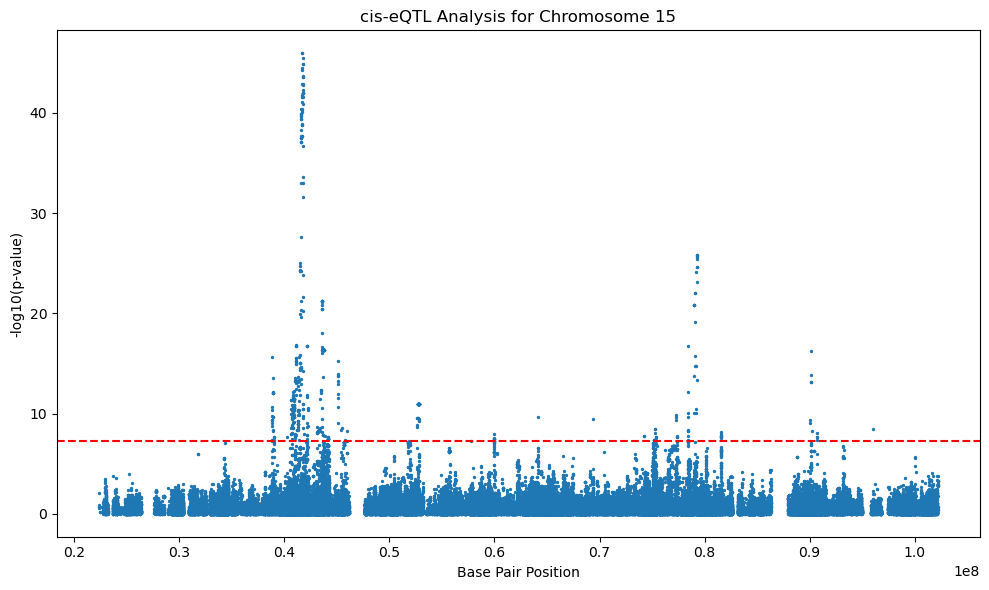

In [24]:
# an overview of cis-eQTL for chr15

temp_df = pd.read_csv(f'result/eqtl/ciseqtl_chr15.txt', index_col='Unnamed: 0')
temp_df['-log10(P)'] = -np.log10(temp_df['P'])

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(temp_df['BP'], temp_df['-log10(P)'], s=2)
ax.set_xlabel('Base Pair Position')
ax.set_ylabel('-log10(p-value)')
ax.set_title(f'cis-eQTL Analysis for Chromosome 15')
ax.axhline(y=-np.log10(5e-8), color='r', linestyle='--', label='Genome-wide significance')
plt.tight_layout()
plt.show()

In [25]:
# Now I will look deeper into the significant peak on chromosome 15 around 0.4
temp_df_15 = pd.read_csv(f'result/eqtl/ciseqtl_chr15.txt', index_col='Unnamed: 0')
peak_BP = temp_df_15[temp_df_15['P'] == temp_df_15['P'].min()]['BP'].iloc[0]
idx = np.abs(genes[genes['CHR']==15]['START'] - peak_BP).idxmin()
gene_of_interst = genes.loc[idx]['ID']


Now, we can also look at that specefic gene, including the cis-eQTL assocaitions and linkage disequilibrium, using LocusZoom (https://statgen.github.io/localzoom/)
<br>
Below is the code to generate the data to be upload to LocusZoom...

In [26]:
%%bash
mkdir -p result/locuszoom

In [27]:
gene_df = temp_df_15[(temp_df_15['BP'] >= genes[genes['ID'] == gene_of_interst]['START'].iloc[0]-500000) & (temp_df_15['BP'] <= genes[genes['ID'] == gene_of_interst]['STOP'].iloc[0]+500000)]
gene_df = gene_df.sort_values(by=['CHR', 'BP'])
gene_df.to_csv(f'result/locuszoom/locuszoom_{15}_{gene_of_interst}.txt', sep='\t', index=False)

In [28]:
%%bash
bgzip -c result/locuszoom/locuszoom_15_MGA.txt > result/locuszoom/locuszoom_15_MGA.txt.gz
tabix -s 1 -b 2 -e 2 result/locuszoom/locuszoom_15_MGA.txt.gz

[E::get_intv] Failed to parse TBX_GENERIC, was wrong -p [type] used?
The offending line was: "CHR	BP	REF	ALT	P	BETA	SE	SNP"


### PRS with eQTL summary data
In this section, I will develop a PRS using eQTL summary data. I focus on a signle gene MGA (Predicted to be involved in cell fate specification and positive regulation of transcription by RNA polymerase II).

#### split datasets into train, valid, test with 5-3-2 split

In [29]:
%%bash
mkdir -p temp_dir/prs_eqtl

In [30]:
all_ids = fam['iid'][overlap_idx_genome].tolist()  
random.seed(42)
random.shuffle(all_ids)
total_count = len(all_ids)

# Splitting into 50%-30%-20% for train, validation, and test sets
train_count = int(total_count * 0.50)
valid_count = int(total_count * 0.30)
train_ids = all_ids[:train_count]
valid_ids = all_ids[train_count:train_count + valid_count]
test_ids = all_ids[train_count + valid_count:]

train_ids_df = fam[fam['iid'].isin(train_ids)]
valid_ids_df = fam[fam['iid'].isin(valid_ids)]
test_ids_df = fam[fam['iid'].isin(test_ids)]
train_ids_df[['fid', 'iid']].to_csv('temp_dir/prs_eqtl/train_keep.txt', sep=' ', header=False, index=False)
valid_ids_df[['fid', 'iid']].to_csv('temp_dir/prs_eqtl/valid_keep.txt', sep=' ', header=False, index=False)
test_ids_df[['fid', 'iid']].to_csv('temp_dir/prs_eqtl/test_keep.txt', sep=' ', header=False, index=False)


In [31]:
%%bash
./plink2 --bfile temp_dir/eqtl/plink_files/1000G.EUR.15.MGA --keep temp_dir/prs_eqtl/train_keep.txt --make-bed --out temp_dir/prs_eqtl/15_MGA_train
./plink2 --bfile temp_dir/eqtl/plink_files/1000G.EUR.15.MGA --keep temp_dir/prs_eqtl/valid_keep.txt --make-bed --out temp_dir/prs_eqtl/15_MGA_valid
./plink2 --bfile temp_dir/eqtl/plink_files/1000G.EUR.15.MGA --keep temp_dir/prs_eqtl/test_keep.txt --make-bed --out temp_dir/prs_eqtl/15_MGA_test


PLINK v2.0.0-a.6.3 M1 (3 Dec 2024)                 cog-genomics.org/plink/2.0/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to temp_dir/prs_eqtl/15_MGA_train.log.
Options in effect:
  --bfile temp_dir/eqtl/plink_files/1000G.EUR.15.MGA
  --keep temp_dir/prs_eqtl/train_keep.txt
  --make-bed
  --out temp_dir/prs_eqtl/15_MGA_train

Start time: Thu Dec  5 00:49:21 2024
18432 MiB RAM detected; reserving 9216 MiB for main workspace.
Using up to 11 threads (change this with --threads).
489 samples (0 females, 0 males, 489 ambiguous; 489 founders) loaded from
temp_dir/eqtl/plink_files/1000G.EUR.15.MGA.fam.
363 variants loaded from temp_dir/eqtl/plink_files/1000G.EUR.15.MGA.bim.
Note: No phenotype data present.
--keep: 172 samples remaining.
172 samples (0 females, 0 males, 172 ambiguous; 172 founders) remaining after
main filters.
Writing temp_dir/prs_eqtl/15_MGA_train.fam ... done.
Writing temp_dir/prs_eqtl/15_MGA_train.bim ... done.
Writing temp_dir/p

#### run PRS

In [32]:
%%bash
p_val=0.1
r2=0.1
./plink2 --bfile temp_dir/prs_eqtl/15_MGA_train --clump-p1 $p_val --clump-r2 $r2 --clump-kb 250 --clump result/locuszoom/locuszoom_15_MGA.txt --clump-snp-field SNP --clump-field P --out temp_dir/prs_eqtl/15_MGA_train

PLINK v2.0.0-a.6.3 M1 (3 Dec 2024)                 cog-genomics.org/plink/2.0/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to temp_dir/prs_eqtl/15_MGA_train.log.
Options in effect:
  --bfile temp_dir/prs_eqtl/15_MGA_train
  --clump result/locuszoom/locuszoom_15_MGA.txt
  --clump-id-field SNP
  --clump-kb 250
  --clump-p-field P
  --clump-p1 0.1
  --clump-r2 0.1
  --out temp_dir/prs_eqtl/15_MGA_train

Start time: Thu Dec  5 00:49:21 2024
18432 MiB RAM detected; reserving 9216 MiB for main workspace.
Using up to 11 threads (change this with --threads).
172 samples (0 females, 0 males, 172 ambiguous; 172 founders) loaded from
temp_dir/prs_eqtl/15_MGA_train.fam.
363 variants loaded from temp_dir/prs_eqtl/15_MGA_train.bim.
Note: No phenotype data present.
--clump: 31 clumps formed from 349 index candidates.  
Results written to temp_dir/prs_eqtl/15_MGA_train.clumps .
End time: Thu Dec  5 00:49:21 2024


In [33]:
%%bash
# Extract SNPs from clumped output (skipping the header line)
awk 'NR!=1 {print $3}' temp_dir/prs_eqtl/15_MGA_train.clumps > temp_dir/prs_eqtl/MGA.valid.snp

# Extract columns 8 and 5 from the locuszoom file and save to a new file
awk '{print $8, $5}' result/locuszoom/locuszoom_15_MGA.txt > temp_dir/prs_eqtl/SNP.pvalue

In [34]:
score_file = 'result/locuszoom/locuszoom_15_MGA.txt'
df = pd.read_csv(score_file, sep='\t')
df_unique = df.drop_duplicates(subset='SNP')
df_unique.to_csv('temp_dir/prs_eqtl/locuszoom_15_MGA_unique.txt', sep='\t', index=False)

In [35]:
%%bash
mkdir -p result/eqtl_prs
echo "0.001 0 0.001" > temp_dir/prs_eqtl/range_list
./plink2 --bfile temp_dir/prs_eqtl/15_MGA_valid \
    --score temp_dir/prs_eqtl/locuszoom_15_MGA_unique.txt 8 3 6 header \
    --q-score-range temp_dir/prs_eqtl/range_list temp_dir/prs_eqtl/SNP.pvalue min \
    --extract temp_dir/prs_eqtl/MGA.valid.snp \
    --out result/eqtl_prs/val001
rm result/eqtl_prs/*.log

PLINK v2.0.0-a.6.3 M1 (3 Dec 2024)                 cog-genomics.org/plink/2.0/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to result/eqtl_prs/val001.log.
Options in effect:
  --bfile temp_dir/prs_eqtl/15_MGA_valid
  --extract temp_dir/prs_eqtl/MGA.valid.snp
  --out result/eqtl_prs/val001
  --q-score-range temp_dir/prs_eqtl/range_list temp_dir/prs_eqtl/SNP.pvalue min
  --score temp_dir/prs_eqtl/locuszoom_15_MGA_unique.txt 8 3 6 header

Start time: Thu Dec  5 00:49:21 2024
18432 MiB RAM detected; reserving 9216 MiB for main workspace.
Using up to 11 threads (change this with --threads).
103 samples (0 females, 0 males, 103 ambiguous; 103 founders) loaded from
temp_dir/prs_eqtl/15_MGA_valid.fam.
363 variants loaded from temp_dir/prs_eqtl/15_MGA_valid.bim.
Note: No phenotype data present.
--extract: 31 variants remaining.
Calculating allele frequencies... done.
31 variants remaining after main filters.
--q-score-range: 1 range and 31 variants load

were skipped due to missing variant IDs.
(Add the 'list-variants' modifier to see which variants were actually used for
scoring.)


In [36]:
predicted_expression = pd.read_csv('result/eqtl_prs/val001.0.001.sscore', sep='\t')['SCORE1_AVG']
all_true_expression = gene_exp_overlap[gene_exp_overlap['SYM'] == genes[genes['ID'] == 'MGA']['SYM'].iloc[0]].iloc[0]
valid_true_expression = [all_true_expression.loc[id] for id in valid_ids_df['iid']]
correlation = np.corrcoef(predicted_expression, valid_true_expression)[0, 1]
r_squared = correlation ** 2
print(f'p-value 0.001 r-squared {r_squared}')

p-value 0.001 r-squared 0.0003503328609654767


In [37]:
%%bash
mkdir -p result/eqtl_prs
echo "0.05 0 0.05" > temp_dir/prs_eqtl/range_list
./plink2 --bfile temp_dir/prs_eqtl/15_MGA_valid \
    --score temp_dir/prs_eqtl/locuszoom_15_MGA_unique.txt 8 3 6 header \
    --q-score-range temp_dir/prs_eqtl/range_list temp_dir/prs_eqtl/SNP.pvalue min \
    --extract temp_dir/prs_eqtl/MGA.valid.snp \
    --out result/eqtl_prs/val05
rm result/eqtl_prs/*.log

PLINK v2.0.0-a.6.3 M1 (3 Dec 2024)                 cog-genomics.org/plink/2.0/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to result/eqtl_prs/val05.log.
Options in effect:
  --bfile temp_dir/prs_eqtl/15_MGA_valid
  --extract temp_dir/prs_eqtl/MGA.valid.snp
  --out result/eqtl_prs/val05
  --q-score-range temp_dir/prs_eqtl/range_list temp_dir/prs_eqtl/SNP.pvalue min
  --score temp_dir/prs_eqtl/locuszoom_15_MGA_unique.txt 8 3 6 header

Start time: Thu Dec  5 00:49:21 2024
18432 MiB RAM detected; reserving 9216 MiB for main workspace.
Using up to 11 threads (change this with --threads).
103 samples (0 females, 0 males, 103 ambiguous; 103 founders) loaded from
temp_dir/prs_eqtl/15_MGA_valid.fam.
363 variants loaded from temp_dir/prs_eqtl/15_MGA_valid.bim.
Note: No phenotype data present.
--extract: 31 variants remaining.
Calculating allele frequencies... done.
31 variants remaining after main filters.
--q-score-range: 1 range and 31 variants loaded

were skipped due to missing variant IDs.
(Add the 'list-variants' modifier to see which variants were actually used for
scoring.)


In [38]:
predicted_expression = pd.read_csv('result/eqtl_prs/val05.0.05.sscore', sep='\t')['SCORE1_AVG']
all_true_expression = gene_exp_overlap[gene_exp_overlap['SYM'] == genes[genes['ID'] == 'MGA']['SYM'].iloc[0]].iloc[0]
valid_true_expression = [all_true_expression.loc[id] for id in valid_ids_df['iid']]
correlation = np.corrcoef(predicted_expression, valid_true_expression)[0, 1]
r_squared = correlation ** 2
print(f'p-value 0.05 r-squared {r_squared}')

p-value 0.05 r-squared 0.00011165041238056419


In [39]:
%%bash
mkdir -p result/eqtl_prs
echo "0.1 0 0.1" > temp_dir/prs_eqtl/range_list
./plink2 --bfile temp_dir/prs_eqtl/15_MGA_valid \
    --score temp_dir/prs_eqtl/locuszoom_15_MGA_unique.txt 8 3 6 header \
    --q-score-range temp_dir/prs_eqtl/range_list temp_dir/prs_eqtl/SNP.pvalue min \
    --extract temp_dir/prs_eqtl/MGA.valid.snp \
    --out result/eqtl_prs/val1
rm result/eqtl_prs/*.log

PLINK v2.0.0-a.6.3 M1 (3 Dec 2024)                 cog-genomics.org/plink/2.0/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to result/eqtl_prs/val1.log.
Options in effect:
  --bfile temp_dir/prs_eqtl/15_MGA_valid
  --extract temp_dir/prs_eqtl/MGA.valid.snp
  --out result/eqtl_prs/val1
  --q-score-range temp_dir/prs_eqtl/range_list temp_dir/prs_eqtl/SNP.pvalue min
  --score temp_dir/prs_eqtl/locuszoom_15_MGA_unique.txt 8 3 6 header

Start time: Thu Dec  5 00:49:21 2024
18432 MiB RAM detected; reserving 9216 MiB for main workspace.
Using up to 11 threads (change this with --threads).
103 samples (0 females, 0 males, 103 ambiguous; 103 founders) loaded from
temp_dir/prs_eqtl/15_MGA_valid.fam.
363 variants loaded from temp_dir/prs_eqtl/15_MGA_valid.bim.
Note: No phenotype data present.
--extract: 31 variants remaining.
Calculating allele frequencies... done.
31 variants remaining after main filters.
--q-score-range: 1 range and 31 variants loaded.


were skipped due to missing variant IDs.
(Add the 'list-variants' modifier to see which variants were actually used for
scoring.)


In [40]:
predicted_expression = pd.read_csv('result/eqtl_prs/val1.0.1.sscore', sep='\t')['SCORE1_AVG']
all_true_expression = gene_exp_overlap[gene_exp_overlap['SYM'] == genes[genes['ID'] == 'MGA']['SYM'].iloc[0]].iloc[0]
valid_true_expression = [all_true_expression.loc[id] for id in valid_ids_df['iid']]
correlation = np.corrcoef(predicted_expression, valid_true_expression)[0, 1]
r_squared = correlation ** 2
print(f'p-value 0.1 r-squared {r_squared}')

p-value 0.1 r-squared 0.00633265474072352


it seems that when p-value is 0.01, the r-squared for valid set is the highest.

#### Test accuracy

In [41]:
%%bash
mkdir -p result/eqtl_prs
echo "0.1 0 0.1" > temp_dir/prs_eqtl/range_list
./plink2 --bfile temp_dir/prs_eqtl/15_MGA_test \
    --score temp_dir/prs_eqtl/locuszoom_15_MGA_unique.txt 8 3 6 header \
    --q-score-range temp_dir/prs_eqtl/range_list temp_dir/prs_eqtl/SNP.pvalue min \
    --extract temp_dir/prs_eqtl/MGA.valid.snp \
    --out result/eqtl_prs/test
rm result/eqtl_prs/*.log

PLINK v2.0.0-a.6.3 M1 (3 Dec 2024)                 cog-genomics.org/plink/2.0/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to result/eqtl_prs/test.log.
Options in effect:
  --bfile temp_dir/prs_eqtl/15_MGA_test
  --extract temp_dir/prs_eqtl/MGA.valid.snp
  --out result/eqtl_prs/test
  --q-score-range temp_dir/prs_eqtl/range_list temp_dir/prs_eqtl/SNP.pvalue min
  --score temp_dir/prs_eqtl/locuszoom_15_MGA_unique.txt 8 3 6 header

Start time: Thu Dec  5 00:49:21 2024
18432 MiB RAM detected; reserving 9216 MiB for main workspace.
Using up to 11 threads (change this with --threads).
69 samples (0 females, 0 males, 69 ambiguous; 69 founders) loaded from
temp_dir/prs_eqtl/15_MGA_test.fam.
363 variants loaded from temp_dir/prs_eqtl/15_MGA_test.bim.
Note: No phenotype data present.
--extract: 31 variants remaining.
Calculating allele frequencies... done.
31 variants remaining after main filters.
--q-score-range: 1 range and 31 variants loaded.
--scor

were skipped due to missing variant IDs.
(Add the 'list-variants' modifier to see which variants were actually used for
scoring.)


In [42]:
predicted_expression = pd.read_csv('result/eqtl_prs/test.0.1.sscore', sep='\t')['SCORE1_AVG']
all_true_expression = gene_exp_overlap[gene_exp_overlap['SYM'] == genes[genes['ID'] == 'MGA']['SYM'].iloc[0]].iloc[0]
valid_true_expression = [all_true_expression.loc[id] for id in test_ids_df['iid']]
correlation = np.corrcoef(predicted_expression, valid_true_expression)[0, 1]
r_squared = correlation ** 2
print(f'p-value 0.1 r-squared {r_squared}')

p-value 0.1 r-squared 0.017212176808748054


### PRS with GWAS heigh summary data


In [43]:
%%bash
mkdir -p temp_dir/prs_gwas
mkdir -p result/prs_gwas

I already merged Tiffany's genome data obtained from 23andme with the 1000 Genome (chromosome 17).

In [44]:
dat = pd.read_csv("data/Height.gwas.txt.gz", compression='gzip', header=0, sep="\t")
dat['BETA'] = np.log(dat['OR'])
dat.to_csv("temp_dir/prs_gwas/Height.QC.Transformed", sep="\t", index=False, quoting=False)

In [45]:
%%bash
./plink2 \
    --bfile data/merged_17 \
    --clump-p1 0.01 \
    --clump-r2 0.01 \
    --clump-kb 250 \
    --clump temp_dir/prs_gwas/Height.QC.Transformed \
    --clump-snp-field SNP \
    --clump-field P \
    --out temp_dir/prs_gwas/merged_17

PLINK v2.0.0-a.6.3 M1 (3 Dec 2024)                 cog-genomics.org/plink/2.0/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to temp_dir/prs_gwas/merged_17.log.
Options in effect:
  --bfile data/merged_17
  --clump temp_dir/prs_gwas/Height.QC.Transformed
  --clump-id-field SNP
  --clump-kb 250
  --clump-p-field P
  --clump-p1 0.01
  --clump-r2 0.01
  --out temp_dir/prs_gwas/merged_17

Start time: Thu Dec  5 00:49:25 2024
18432 MiB RAM detected; reserving 9216 MiB for main workspace.
Using up to 11 threads (change this with --threads).
490 samples (0 females, 0 males, 490 ambiguous; 490 founders) loaded from
data/merged_17.fam.
184770 variants loaded from data/merged_17.bim.
Note: No phenotype data present.


written to temp_dir/prs_gwas/merged_17.clumps.missing_id .


--clump: 4976 clumps formed from 7688 index candidates.  
Results written to temp_dir/prs_gwas/merged_17.clumps .
End time: Thu Dec  5 00:49:25 2024


In [46]:
%%bash
awk 'NR!=1{print $3}' temp_dir/prs_gwas/merged_17.clumps >  temp_dir/prs_gwas/merged_17.valid.snp
awk '{print $3,$8}' temp_dir/prs_gwas/Height.QC.Transformed > temp_dir/prs_gwas/SNP.pvalue
echo "0.1 0 0.1" >> temp_dir/prs_gwas/range_list

In [47]:
%%bash
./plink2 \
    --bfile data/merged_17 \
    --score temp_dir/prs_gwas/Height.QC.Transformed 3 4 12 header \
    --q-score-range temp_dir/prs_gwas/range_list temp_dir/prs_gwas/SNP.pvalue \
    --extract temp_dir/prs_gwas/merged_17.valid.snp \
    --out result/prs_gwas/merged_17

PLINK v2.0.0-a.6.3 M1 (3 Dec 2024)                 cog-genomics.org/plink/2.0/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to result/prs_gwas/merged_17.log.
Options in effect:
  --bfile data/merged_17
  --extract temp_dir/prs_gwas/merged_17.valid.snp
  --out result/prs_gwas/merged_17
  --q-score-range temp_dir/prs_gwas/range_list temp_dir/prs_gwas/SNP.pvalue
  --score temp_dir/prs_gwas/Height.QC.Transformed 3 4 12 header

Start time: Thu Dec  5 00:49:27 2024
18432 MiB RAM detected; reserving 9216 MiB for main workspace.
Using up to 11 threads (change this with --threads).
490 samples (0 females, 0 males, 490 ambiguous; 490 founders) loaded from
data/merged_17.fam.
184770 variants loaded from data/merged_17.bim.
Note: No phenotype data present.
--extract: 4976 variants remaining.
Calculating allele frequencies... 4680done.
4976 variants remaining after main filters.
--q-score-range: 1 range and 4976 variants loaded.


were skipped due to missing variant IDs.
(Add the 'list-variants' modifier to see which variants were actually used for
scoring.)


--score: 4976 variants processed.
--score + --q-score-range: Results written to result/prs_gwas/merged_17.<range
name>.sscore .
End time: Thu Dec  5 00:49:27 2024


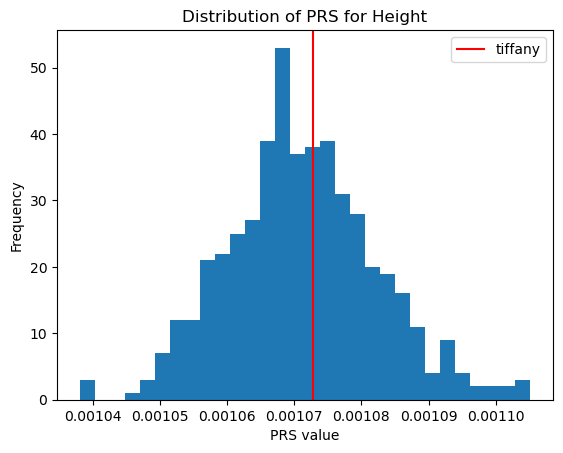

In [48]:
t5 = pd.read_csv('result/prs_gwas/merged_17.0.1.sscore', sep='\t')
t5[t5['IID'] == 'tiffany']['SCORE1_AVG'].iloc[0]
plt.hist(t5['SCORE1_AVG'], bins=30);
plt.axvline(x=t5[t5['IID'] == 'tiffany']['SCORE1_AVG'].iloc[0], c='red', label='tiffany');
plt.legend();
plt.xlabel('PRS value')
plt.ylabel('Frequency')
plt.title('Distribution of PRS for Height')
plt.show()